In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import json
import datetime as dt

from pycaret.classification import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)


# Part1
The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15-minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [2]:
df_logins = pd.read_json('logins.json')


In [3]:
df_logins

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21
...,...
93137,1970-04-13 18:50:19
93138,1970-04-13 18:43:56
93139,1970-04-13 18:54:02
93140,1970-04-13 18:57:38


In [4]:
df_logins.dtypes

login_time    datetime64[ns]
dtype: object

### Aggregate login counts based on 15-min time interval

In [5]:
df_15_dt = df_logins.resample('15min', on='login_time').count().rename(columns={'login_time': 'login_count'})
df_15_dt.head(10)

,login_count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1
1970-01-01 21:15:00,4
1970-01-01 21:30:00,0
1970-01-01 21:45:00,4
1970-01-01 22:00:00,9


In [6]:
df_15_dt['month'] = df_15_dt.index.month 
df_15_dt['diff'] = df_15_dt.login_count.diff()

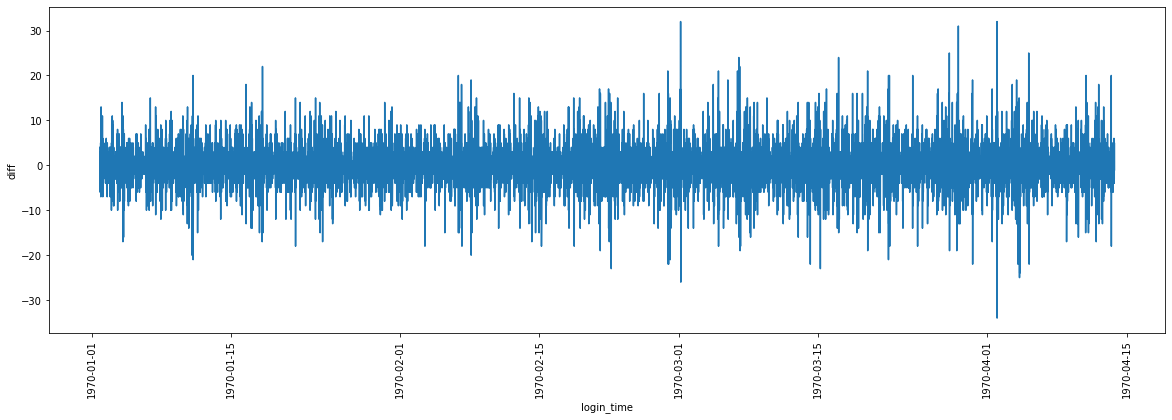

In [7]:
plt.figure(figsize=(20, 6))
sns.lineplot(data=df_15_dt, x='login_time', y='diff')
plt.xticks(rotation=90)
plt.show()

From overall diff between each day is not giving us any clear trends in the data. Let's plot the data for a single month to see if there is weekly trends.

In [8]:
df_jan = df_15_dt[df_15_dt.month == 1]

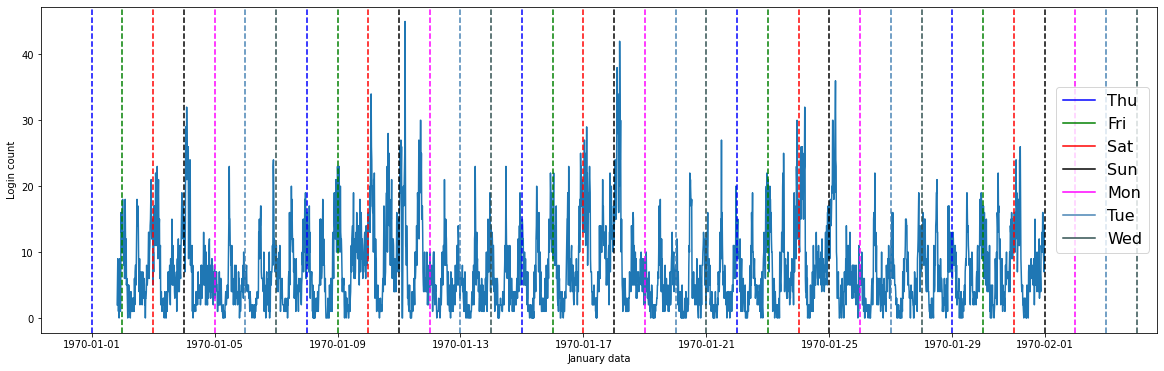

In [9]:
plt.figure(figsize=(20, 6))
lp = sns.lineplot(data=df_jan, x='login_time', y='login_count')
ax = lp.axes
plt.xlabel('January data')
plt.ylabel('Login count')
c = ['blue', 'green', 'red', 'black', 'magenta', 'steelblue', 'darkslategray']
leg = []
weekday = dict(zip(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']))
for i in range(7):
    temp = dt.datetime(1970, 1, 1) + dt.timedelta(days=i)
    leg.append(Line2D([0], [0], color=c[i], label=weekday[temp.weekday()]))
    day_data = [temp + dt.timedelta(days=7 * i) for i in range(5)]
    for data in day_data:
        plt.axvline(data, color=c[i], linestyle='--')

ax.legend(handles=leg, loc='right', prop={'size': 16})
plt.show()

There is almost always a spike in login at the begining (12 PM) of the day and in the afternoon. There might be some missing data which might make it harder to identify any other periodicity in the data. The two peak might happen due to lunch break and commute to home after work.

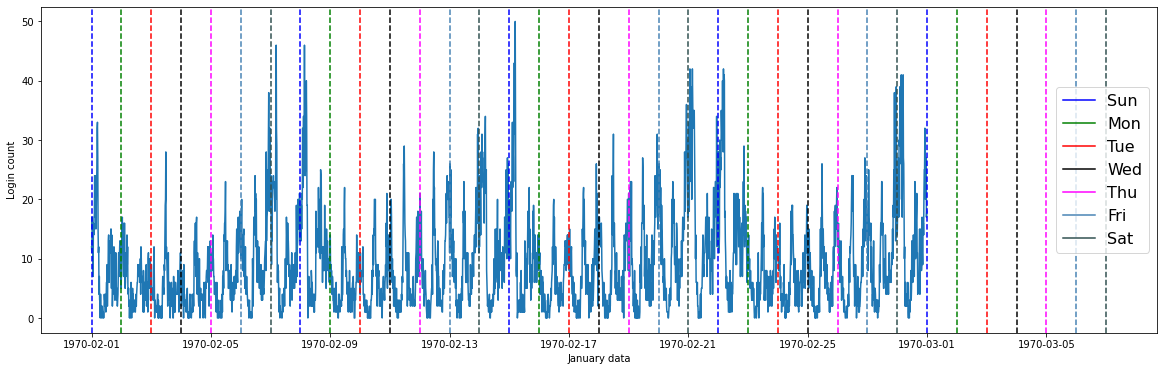

In [10]:
df_feb = df_15_dt[df_15_dt.month == 2]
plt.figure(figsize=(20, 6))
lp = sns.lineplot(data=df_feb, x='login_time', y='login_count')
ax = lp.axes
plt.xlabel('January data')
plt.ylabel('Login count')
c = ['blue', 'green', 'red', 'black', 'magenta', 'steelblue', 'darkslategray']
leg = []
weekday = dict(zip(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']))
for i in range(7):
    temp = dt.datetime(1970, 2, 1) + dt.timedelta(days=i)
    leg.append(Line2D([0], [0], color=c[i], label=weekday[temp.weekday()]))
    day_data = [temp + dt.timedelta(days=7 * i) for i in range(5)]
    for data in day_data:
        plt.axvline(data, color=c[i], linestyle='--')

ax.legend(handles=leg, loc='right', prop={'size': 16})
plt.show()

### Part 2 ‑ Experiment and metrics design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities. However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

Answer: How many drivers are available in both cities at the same time. If a driver is available at both cities at the same time, it will mean the driver is able to take advantage of the toll incentive provided by the company. 


2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

a. how you will implement the experiment

Answer: The obvious choice would be to run an A/B test with two groups (one having no changes in the app and another with the reminder that they will be reimbursed all toll costs). 


b. what statistical test(s) you will conduct to verify the significance of the observation

Answer: The null hypothesis should be there is no difference between the two groups and the alternative hypothesis is that there is indeed a differece between the two groups. Since we are only interested in if it inceases the sells, a one tailed test should be enough to reject the null hypothesis. 

c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.

Answer: A p value signifying 95% confidence levels will help us reject the null hypothesis. Based on the p value, I would recommend wheather this incentive is important or not. 



## Part 3 ‑ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention (again, a few sentences will suffice).
Data description

1. city: city this user signed up in
2. phone: primary device for this user
3. signup_date: date of account registration; in the form ‘YYYY MM DD’
4. last_trip_date: the last time this user completed a trip; in the form ‘YYYY MM DD’
5. avg_dist: the average distance in miles per trip taken in the first 30 days after signup
6. avg_rating_by_driver: the rider’s average rating over all of their trips
7. avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
8. surge_pct: the percent of trips taken with surge multiplier > 1
9. avg_surge: The average surge multiplier over all of this user’s trips
10. trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
11. ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
12. weekday_pct: the percent of the user’s trips occurring during a weekday



In [11]:
df = pd.read_json('ultimate_data_challenge.json')
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [12]:
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

In [13]:
df.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

In [31]:
# Fill in the missing value with the mean values
df['phone'].fillna(value='N/A', inplace=True)
df['avg_rating_of_driver'].fillna(value=df['avg_rating_of_driver'].mean(), inplace=True)
df['avg_rating_by_driver'].fillna(value=df['avg_rating_by_driver'].mean(), inplace=True)


In [15]:
df

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.700000,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.000000,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.300000,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.600000,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.400000,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,2014-01-25,5.000000,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,4.601559,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0
49997,Winterfell,0,2014-01-31,5.000000,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.000000,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5


In [16]:
# if the last trip was within last 30 days of the most recent trip then we will consider it to be retained
retain_window = max(df.last_trip_date) - dt.timedelta(days=30)
df['retained'] = df.apply(lambda x: 1 if x.last_trip_date > retain_window else 0, axis=1)

In [17]:
df.drop(['signup_date', 'last_trip_date'], axis=1, inplace=True)

In [18]:
df.dtypes

city                       object
trips_in_first_30_days      int64
avg_rating_of_driver      float64
avg_surge                 float64
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
retained                    int64
dtype: object

In [19]:
df

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,4.700000,1.10,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,5.000000,1.00,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,4.300000,1.00,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,4.600000,1.14,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,4.400000,1.19,Android,11.8,False,82.4,3.13,4.9,0
...,...,...,...,...,...,...,...,...,...,...,...
49995,King's Landing,0,5.000000,1.00,iPhone,0.0,False,100.0,5.63,4.2,1
49996,Astapor,1,4.601559,1.00,iPhone,0.0,False,0.0,0.00,4.0,0
49997,Winterfell,0,5.000000,1.00,Android,0.0,True,100.0,3.86,5.0,0
49998,Astapor,2,3.000000,1.00,iPhone,0.0,False,100.0,4.58,3.5,0


In [20]:
# Setup the pycaret classifier environment
clf_setup = setup(data = df, 
                  target = 'retained', 
                  session_id=123,
                  normalize = True, 
                  transformation = True, 
                  ignore_low_variance = True,
                  fix_imbalance=True,
                  remove_multicollinearity = True, 
                  multicollinearity_threshold = 0.9,
                  categorical_features=['city', 'phone', 'ultimate_black_user'],
                  log_experiment = True, 
                  experiment_name = 'ultimate',
                  train_size=0.75,
                  remove_outliers=True,
                  outliers_threshold=0.05)

,Description,Value
0,session_id,123
1,Target,retained
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(50000, 11)"
5,Missing Values,False
6,Numeric Features,7
7,Categorical Features,3
8,Ordinal Features,False
9,High Cardinality Features,False


In [21]:
# Get top 5 models
top_5_model = compare_models(fold=5,
                           sort="AUC",
                           n_select=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7874,0.8573,0.7203,0.7071,0.7136,0.5446,0.5446,0.2980
catboost,CatBoost Classifier,0.7900,0.8572,0.7059,0.7182,0.7120,0.5467,0.5468,12.2440
xgboost,Extreme Gradient Boosting,0.7862,0.8529,0.6992,0.7136,0.7063,0.5382,0.5383,1.1420
gbc,Gradient Boosting Classifier,0.7771,0.8501,0.7462,0.6793,0.7111,0.5303,0.5319,0.7320
ada,Ada Boost Classifier,0.7712,0.8441,0.7522,0.6678,0.7075,0.5207,0.5232,0.3040
rf,Random Forest Classifier,0.7475,0.8152,0.6964,0.6452,0.6698,0.4659,0.4668,0.7120
nb,Naive Bayes,0.7404,0.8010,0.7072,0.6312,0.6671,0.4554,0.4574,0.4920
et,Extra Trees Classifier,0.7389,0.7937,0.6861,0.6340,0.6590,0.4480,0.4489,0.8160
knn,K Neighbors Classifier,0.7297,0.7860,0.7185,0.6131,0.6616,0.4389,0.4427,0.6960
lr,Logistic Regression,0.7153,0.7823,0.7162,0.5936,0.6492,0.4131,0.4182,0.8520


With very little effort, we could identify that the lightgbm package from microsoft was able to achieve 85+% roc auc. It's very promising result. Let's further tune the best model to further improve the performance.

In [22]:
# Tune the best model
tuned_model = tune_model(estimator=top_5_model[0], fold=5,
                         optimize="AUC", choose_better=True,
                         verbose=False)

In [23]:
# Best parameters are:
plot_model(tuned_model, plot="parameter")

,Parameters
boosting_type,gbdt
class_weight,None
colsample_bytree,1.0
importance_type,split
learning_rate,0.1
max_depth,-1
min_child_samples,66
min_child_weight,0.001
min_split_gain,0.4
n_estimators,90


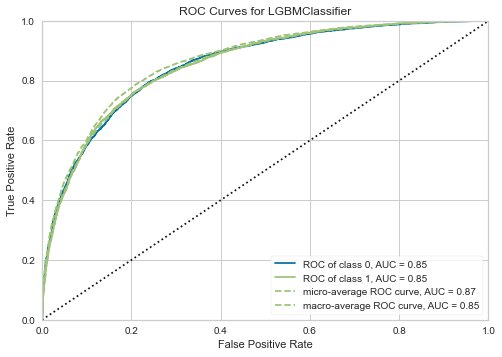

In [24]:
# Plot the roc auc curve
plot_model(tuned_model, plot="auc")

ROC AUC curve looks pretty amazing.

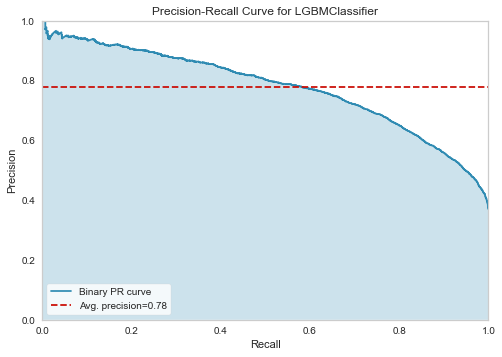

In [25]:
# Precision recall curve
plot_model(tuned_model, plot="pr")

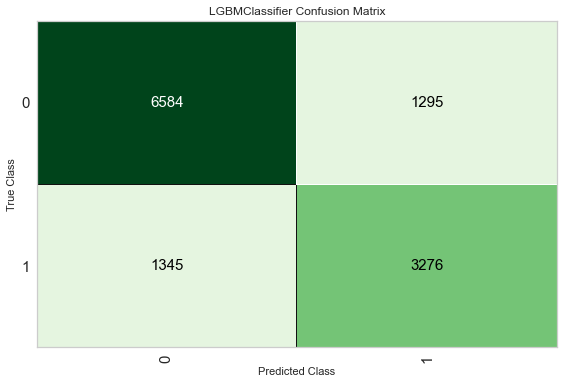

In [26]:
# Plot the confusion matrix
plot_model(tuned_model, plot="confusion_matrix")

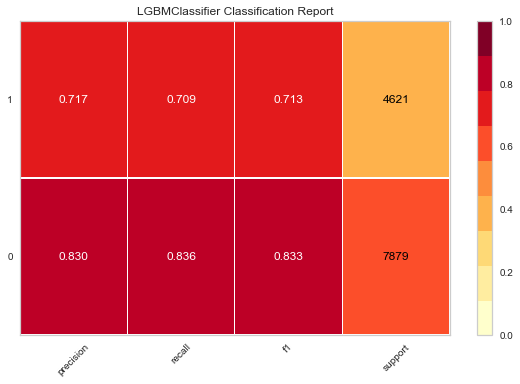

In [27]:
# Plot individual class report which is crucial to judge how the model is performing for both the majority and minority class
plot_model(tuned_model, plot="class_report")

As expected, due to class imbalance the minority label (retained) accuracy is lower than the majority label (not retained). 

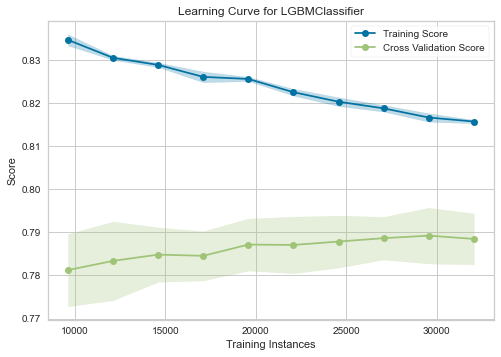

In [28]:
# learning curve
plot_model(tuned_model, plot="learning")

Learning curve indicates the model has further capacity to learn from the data. It might be worthwhile collecting more data to furhter push the accuracy envelope. 

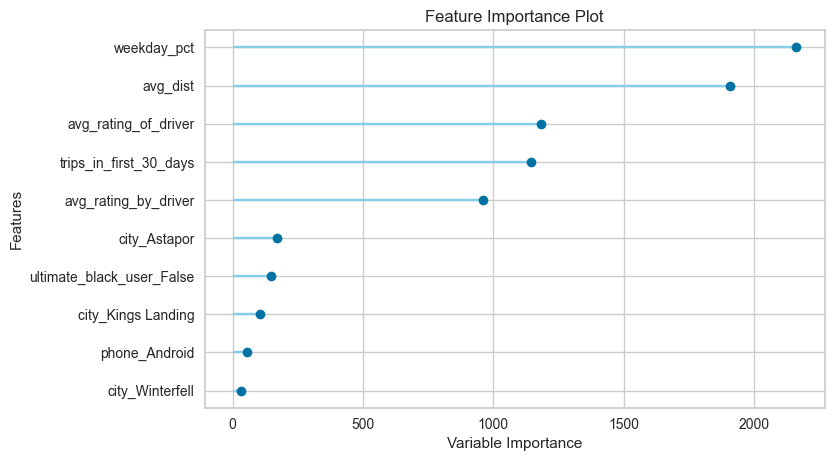

In [29]:
# Feature importance plot
plot_model(tuned_model, plot='feature')

weekday pct, avg_dist, avg_rating of the dirver and by the driver etc. are very important. It might be beneficial to identify driver and passenger with high rating, and passenger who had another trip is the first 30 days and offer them lucrative promotion to increase ultimate black service. 

In [30]:
# Predictive performance of the tuned model
predict_model(tuned_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7888,0.8548,0.7089,0.7167,0.7128,0.5458,0.5458


,trips_in_first_30_days,avg_rating_of_driver,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_Kings Landing,city_Winterfell,phone_Android,ultimate_black_user_False,retained,Label,Score
0,0.894895,-1.260090,-0.021431,-0.089515,-0.080586,0.0,0.0,1.0,0.0,0.0,1,1,0.8706
1,1.362368,-1.033320,-0.021431,0.387951,0.806170,1.0,0.0,0.0,1.0,0.0,0,0,0.7404
2,-1.190414,-1.351626,-0.845981,1.671262,-1.848131,0.0,0.0,1.0,0.0,0.0,1,1,0.5308
3,0.470126,-0.494217,-0.021431,2.252493,0.806170,0.0,1.0,0.0,0.0,0.0,1,1,0.7179
4,-0.203661,0.538661,-1.076602,-0.849480,-0.080586,1.0,0.0,0.0,0.0,1.0,1,1,0.7367
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12495,1.834006,1.031005,0.968540,-0.652938,-0.080586,1.0,0.0,0.0,0.0,0.0,1,1,0.7360
12496,-1.190414,-2.157585,-1.463121,-0.588600,0.806170,0.0,0.0,1.0,1.0,1.0,0,0,0.8848
12497,-0.203661,1.031005,-1.463121,0.201519,0.806170,0.0,1.0,0.0,1.0,0.0,0,0,0.7965
12498,1.703035,0.538661,0.197215,0.642520,-1.024931,1.0,0.0,0.0,0.0,0.0,1,1,0.8402


The performance on the holdout test set is not also bad, but as we saw earlier from learning curve that having more data might improve the fiedelity of the model. 
